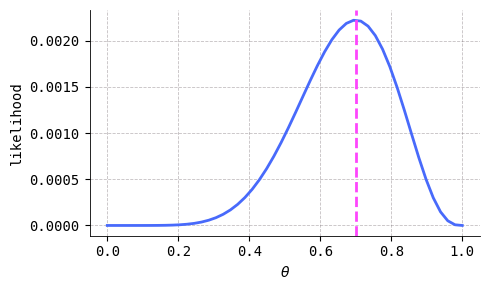

In [1]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from torch.distributions.normal import Normal
from torch.distributions.bernoulli import Bernoulli
import numpy as np
import scipy as sp
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
#import matplotlib_inline.backend_inline
import matplotlib.colors as clr
from collections import defaultdict
import warnings
plt.style.use('./aux-files/custom_style_light.mplstyle')
#matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
warnings.filterwarnings("ignore")
blue = '#486AFB'
magenta = '#FD46FC'

m = 10
x = 7

def likelihood(theta, x, m):
    return (theta ** x) * ((1 - theta) ** (m - x))

predict_grid = np.linspace(0, 1)
plt.plot(predict_grid, likelihood(predict_grid, x, m))
plt.axvline(x=0.7, color=magenta, linestyle='--')
plt.xlabel('$\\theta$')
plt.ylabel('likelihood')
plt.gcf().set_size_inches(w=5, h=3)
plt.tight_layout()

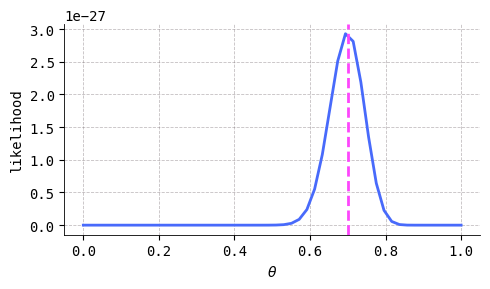

In [2]:
m = 100
x = 70

plt.plot(predict_grid, likelihood(predict_grid, x, m))
plt.axvline(x=0.7, color=magenta, linestyle='--')
plt.xlabel('$\\theta$')
plt.ylabel('likelihood')
plt.gcf().set_size_inches(w=5, h=3)
plt.tight_layout()

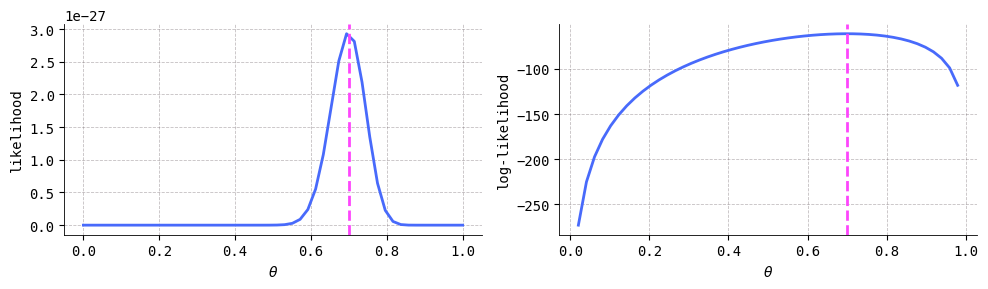

In [3]:
def log_likelihood(theta, x, m):
    return x * np.log(theta) + (m - x) * np.log(1 - theta)

predict_grid = np.linspace(0, 1)
_, axes = plt.subplots(ncols=2, figsize=(10, 3))

axes[0].plot(predict_grid, likelihood(predict_grid, x, m))
axes[1].plot(predict_grid, log_likelihood(predict_grid, x, m))
axes[0].axvline(x=0.7, color=magenta, linestyle='--')
axes[1].axvline(x=0.7, color=magenta, linestyle='--')
axes[0].set_xlabel('$\\theta$')
axes[0].set_ylabel('likelihood')
axes[1].set_xlabel('$\\theta$')
axes[1].set_ylabel('log-likelihood')
plt.tight_layout()

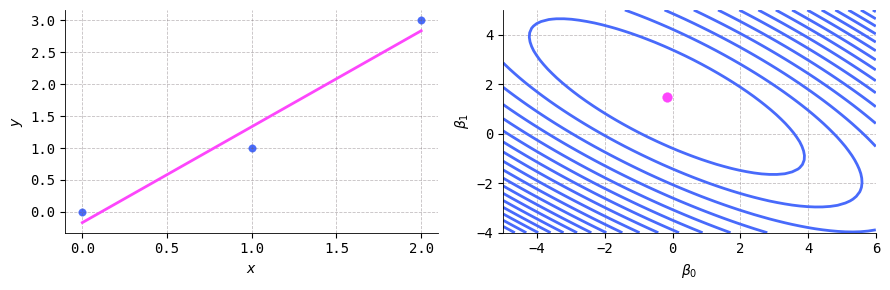

In [4]:
# toy data
X = np.array([[1, 0], [1, 1], [1, 2]])
y = np.array([0, 1, 3]).reshape(-1, 1)

# MLEs for parameters
beta0, beta1 = -1 / 6, 3 / 2

# define objective function
def J(theta, X, y):
    return -0.5 * np.linalg.norm(y - X @ theta, axis=0) ** 2

# define grid
x_grid = np.linspace(-5, 6)
y_grid = np.linspace(-4, 5)
x_grid, y_grid = np.meshgrid(x_grid, y_grid)
predict_grid = np.column_stack((x_grid.reshape(-1, 1), y_grid.reshape(-1, 1))).T
z = J(predict_grid, X, y).reshape(x_grid.shape)

# plot
_, axes = plt.subplots(ncols=2, figsize=(9, 3))

predict_grid = np.linspace(0, 2)
axes[0].scatter(X[:, 1], y, s=30)
axes[0].plot(predict_grid, beta0 + beta1 * predict_grid, color=magenta)
axes[0].set_xlabel('$x$')
axes[0].set_ylabel('$y$')

axes[1].contour(x_grid, y_grid, z, levels=20, colors=blue, linestyles='solid')
axes[1].scatter([beta0], [beta1], s=50, color=magenta)
axes[1].set_xlabel('$\\beta_0$')
axes[1].set_ylabel('$\\beta_1$')

plt.tight_layout()

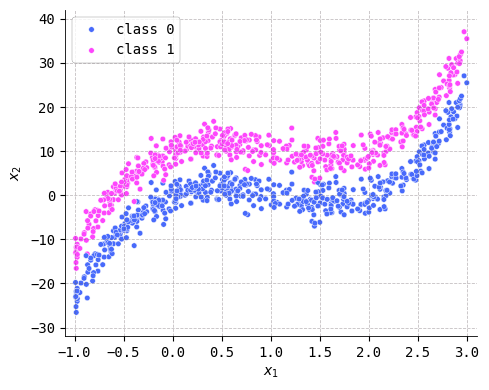

In [5]:
# import the data
url = 'https://raw.githubusercontent.com/jmyers7/stats-book-materials/main/data/ch10-book-data-01.csv'
df = pd.read_csv(url)

# plot the data
g = sns.scatterplot(data=df, x='x_1', y='x_2', hue='y')

# change the default seaborn legend
g.legend_.set_title(None)
new_labels = ['class 0', 'class 1']
for t, l in zip(g.legend_.texts, new_labels):
    t.set_text(l)

plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.xlim(-1.1, 3.1)
plt.ylim(-32, 42)
plt.gcf().set_size_inches(w=5, h=4)
plt.tight_layout()

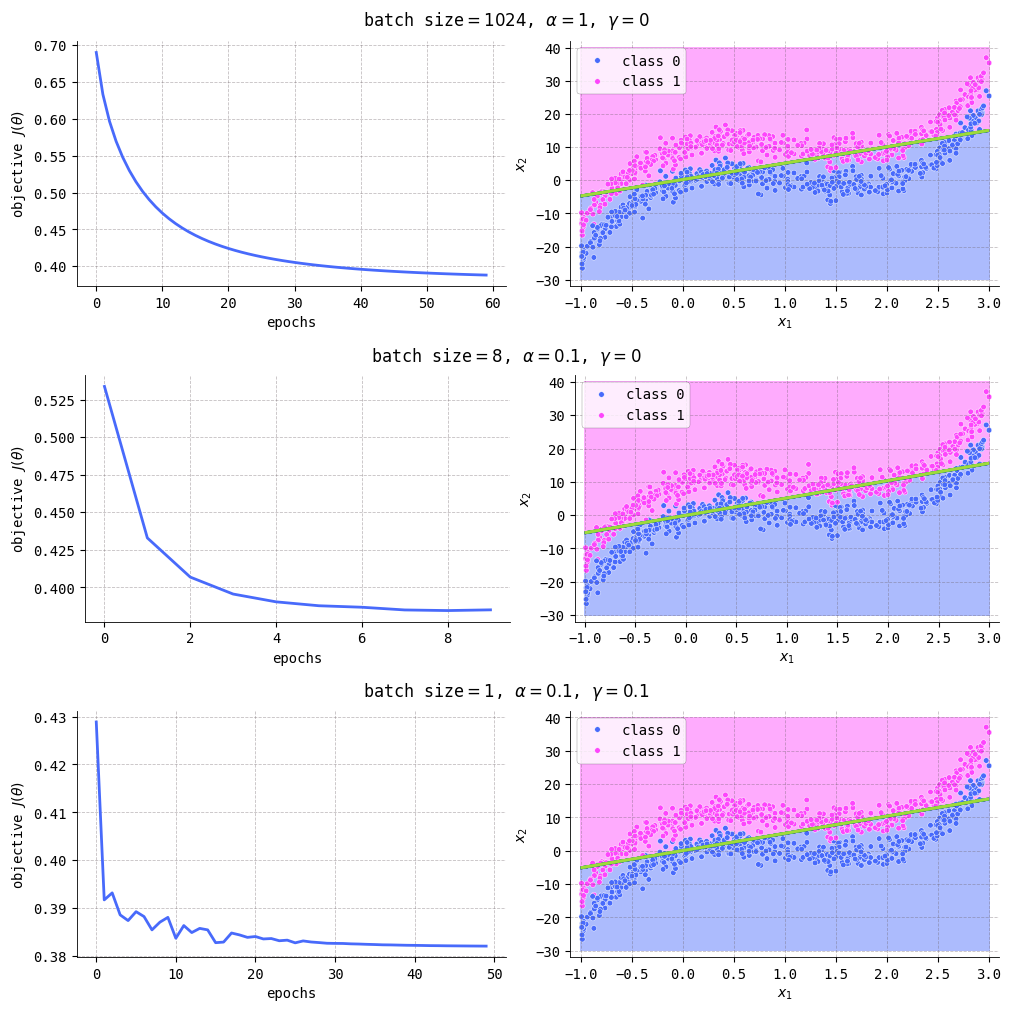

In [6]:
# import scaler from scikit-learn
from sklearn.preprocessing import StandardScaler

# define the SGD function
def SGD(parameters, J, X, num_epochs, batch_size, lr, tracking='epoch', y=None, decay=0, max_steps=-1, J_args=None, shuffle=True, random_state=None):

    # if no arguments to the objective are passed, set `J_args` to the empty dictionary
    J_args = {} if J_args is None else J_args

    # define data loader
    if random_state is not None:
        torch.manual_seed(random_state)
    dataset = TensorDataset(X, y) if y is not None else X
    data_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=shuffle)
    
    # initialize lists and a dictionary to track objectives and parameters
    running_objectives = []
    running_parameters = defaultdict(list)
    step_count = 0

    # begin looping through epochs
    for t in range(num_epochs):
        
        # initialize a list to track per-step objectives. this will only be used if
        # tracking is set to 'epoch'
        per_step_objectives = []
        
        # begin gradient descent loop
        for mini_batch in data_loader:
            
            # `mini_batch` will be a pair of tensors if `y` is not None; otherwise it will be a single tensor. when
            # computing the objective, we need to distinguish the case:
            if y is not None:
                objective = J(*mini_batch, parameters=parameters, **J_args)
            else:
                objective = J(mini_batch, parameters=parameters, **J_args)

            # if we are tracking per gradient step, then add objective value and parameters to the 
            # running lists. otherwise, we are tracking per epoch, so add the objective value to
            # the list of per-step objectives
            if tracking == 'gd_step':
                running_objectives.append(objective.detach().view(1))
                for name, parameter in parameters.items():
                    running_parameters[name].append(parameter.detach().clone())
            else:
                per_step_objectives.append(objective.detach().view(1))
        
            # compute gradients    
            objective.backward()

            # take a gradient step and update the parameters
            with torch.no_grad():
                for parameter in parameters.values():
                    g = ((1 - decay) ** (t + 1)) * parameter.grad
                    parameter -= lr * g
            
            # zero out the gradients to prepare for the next iteration
            for parameter in parameters.values():
                parameter.grad.zero_()

            # if we hit the maximum number of gradient steps, break out of the inner `for`
            # loop
            step_count += 1
            if step_count == max_steps:
                break
        
        # if we are tracking per epoch, then add the average per-step objective to the
        # list of running objectives. also, add the current parameters to the list of running
        # parameters
        if tracking == 'epoch':
            per_step_objectives = torch.row_stack(per_step_objectives)
            running_objectives.append(torch.mean(per_step_objectives))
            for name, parameter in parameters.items():
                running_parameters[name].append(parameter.detach().clone())
        
        # if we hit the maximum number of gradient steps, break out of the outer `for`
        # loop
        if step_count == max_steps:
            break

    return dict(running_parameters), running_objectives

# convert the data to numpy arrays
X = df[['x_1', 'x_2']].to_numpy()
y = df['y'].to_numpy()

# scale the input data
ss = StandardScaler()
X = ss.fit_transform(X=X)

# convert the data to tensors
X = torch.tensor(data=X, dtype=torch.float32)
y = torch.tensor(data=y, dtype=torch.float32).reshape(-1, 1)

# define the objective function for logistic regression
def J(X, y, parameters):
    beta = parameters['beta']
    beta0 = parameters['beta0']
    phi = torch.sigmoid(X @ beta + beta0)
    return -1 * torch.mean(y * torch.log(phi) + (1 - y) * torch.log(1 - phi))

# define the logistic regression model
def model(X, parameters):
    beta = parameters['beta']
    beta0 = parameters['beta0']
    phi = torch.sigmoid(X @ beta + beta0)
    return (phi >= 0.5).to(torch.int)

# define parameters for SGD
sgd_parameters = {'num_epochs': [60, 10, 50],
                  'batch_size': [1024, 8, 1],
                  'lr': [1, 1e-1, 1e-1],
                  'decay': [0, 0, 1e-1]}

# define grid for contour plot
resolution = 1000
x1_grid = np.linspace(-1, 3, resolution)
x2_grid = np.linspace(-30, 40, resolution)
x1_grid, x2_grid = np.meshgrid(x1_grid, x2_grid)
predict_grid = np.column_stack((x1_grid.reshape((resolution ** 2, -1)), x2_grid.reshape((resolution ** 2, -1))))
predict_grid = ss.transform(X=predict_grid)
predict_grid = torch.tensor(data=predict_grid, dtype=torch.float32)

# define color map for contour plot
cmap = clr.LinearSegmentedColormap.from_list('custom', [blue, magenta], N=2)

# define the figure and subfigures
fig = plt.figure(constrained_layout=True, figsize=(10, 10))
subfigs = fig.subfigures(ncols=1, nrows=3)

for i, subfig in enumerate(subfigs):

    # grab SGD parameters
    sgd_parameters_slice = {name: parameter[i] for name, parameter in sgd_parameters.items()}
    batch_size = sgd_parameters_slice['batch_size']
    lr = sgd_parameters_slice['lr']
    decay = sgd_parameters_slice['decay']
    subfig.suptitle(f'batch size$={batch_size}$, $\\alpha = {lr}$, $\\gamma = {decay}$')

    # define the axes per row
    axes = subfig.subplots(ncols=2, nrows=1)

    # initialize the parameters
    torch.manual_seed(42)
    beta = torch.normal(mean=0, std=1e-1, size=(2, 1)).requires_grad_(True)
    beta0 = torch.normal(mean=0, std=1e-1, size=(1,)).requires_grad_(True)
    parameters = {'beta': beta, 'beta0': beta0}

    # run SGD
    running_parameters, running_objectives = SGD(parameters=parameters,
                                                 J=J,
                                                 X=X,
                                                 y=y,
                                                 tracking='epoch',
                                                 **sgd_parameters_slice)

    # plot the objective function
    axes[0].plot(range(len(running_objectives)), running_objectives)
    axes[0].set_xlabel('epochs')
    axes[0].set_ylabel('objective $J(\\theta)$')
    
    # grab the learned parameters
    learned_parameters = {name: parameter[-1] for name, parameter in running_parameters.items()}

    # apply the fitted model to the grid
    z = model(X=predict_grid, parameters=learned_parameters)

    # plot the decision boundary and colors
    z = z.reshape(shape=(resolution, resolution))
    axes[1].contourf(x1_grid, x2_grid, z, cmap=cmap, alpha=0.45)
    axes[1].contour(x1_grid, x2_grid, z)
    axes[1].set_xlabel('$x_1$')
    axes[1].set_ylabel('$x_2$')
    axes[1].set_xlim(-1.1, 3.1)
    axes[1].set_ylim(-32, 42)

    # plot the data
    g = sns.scatterplot(data=df, x='x_1', y='x_2', hue='y', ax=axes[1])

    # change the default seaborn legend
    g.legend_.set_title(None)
    new_labels = ['class 0', 'class 1']
    for t, l in zip(g.legend_.texts, new_labels):
        t.set_text(l)

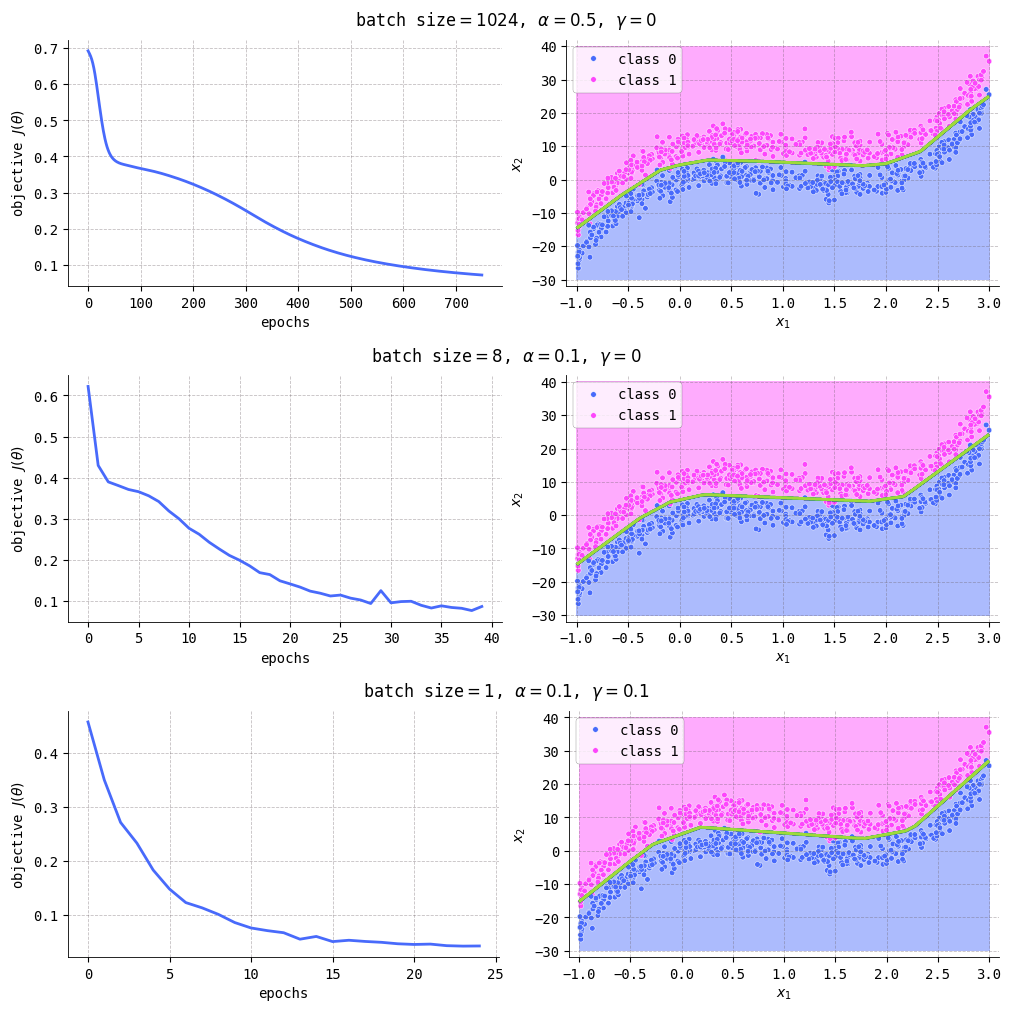

In [7]:
# define the objective function for neural network
def J(X, y, parameters):
    alpha = parameters['alpha']
    alpha0 = parameters['alpha0']
    beta = parameters['beta']
    beta0 = parameters['beta0']
    Z = F.relu(X @ alpha + alpha0)
    phi = torch.sigmoid(Z @ beta + beta0)
    epsilon = 1e-5
    phi = torch.clamp(input=phi, min=epsilon, max=1 - epsilon)
    return -1 * torch.mean(y * torch.log(phi) + (1 - y) * torch.log(1 - phi))

# define the neural network model
def model(X, parameters):
    alpha = parameters['alpha']
    alpha0 = parameters['alpha0']
    beta = parameters['beta']
    beta0 = parameters['beta0']
    Z = F.relu(X @ alpha + alpha0)
    phi = torch.sigmoid(Z @ beta + beta0)
    return (phi >= 0.5).to(torch.int)

# define parameters for SGD
sgd_parameters = {'num_epochs': [750, 40, 25],
                  'batch_size': [1024, 8, 1],
                  'lr': [5e-1, 1e-1, 1e-1],
                  'decay': [0, 0, 1e-1]}

# define the figure and subfigures
fig = plt.figure(constrained_layout=True, figsize=(10, 10))
subfigs = fig.subfigures(ncols=1, nrows=3)

for i, subfig in enumerate(subfigs):

    # grab SGD parameters
    sgd_parameters_slice = {name: parameter[i] for name, parameter in sgd_parameters.items()}
    batch_size = sgd_parameters_slice['batch_size']
    lr = sgd_parameters_slice['lr']
    decay = sgd_parameters_slice['decay']
    subfig.suptitle(f'batch size$={batch_size}$, $\\alpha = {lr}$, $\\gamma = {decay}$')

    # define the axes per row
    axes = subfig.subplots(ncols=2, nrows=1)

    # initialize the parameters
    torch.manual_seed(42)
    k = 16
    alpha = torch.normal(mean=0, std=1e-1, size=(2, k)).requires_grad_(True)
    alpha0 = torch.normal(mean=0, std=1e-1, size=(1, k)).requires_grad_(True)
    beta = torch.normal(mean=0, std=1e-1, size=(k, 1)).requires_grad_(True)
    beta0 = torch.normal(mean=0, std=1e-1, size=(1,)).requires_grad_(True)
    parameters = {'alpha': alpha,
                  'alpha0': alpha0,
                  'beta': beta,
                  'beta0': beta0}

    # run SGD
    running_parameters, running_objectives = SGD(parameters=parameters,
                                                 J=J,
                                                 X=X,
                                                 y=y,
                                                 tracking='epoch',
                                                 **sgd_parameters_slice)

    # plot the objective function
    axes[0].plot(range(len(running_objectives)), running_objectives)
    axes[0].set_xlabel('epochs')
    axes[0].set_ylabel('objective $J(\\theta)$')
    
    # grab the learned parameters
    learned_parameters = {name: parameter[-1] for name, parameter in running_parameters.items()}

    # apply the fitted model to the grid
    z = model(X=predict_grid, parameters=learned_parameters)

    # plot the decision boundary and colors
    z = z.reshape(shape=(resolution, resolution))
    axes[1].contourf(x1_grid, x2_grid, z, cmap=cmap, alpha=0.45)
    axes[1].contour(x1_grid, x2_grid, z)
    axes[1].set_xlabel('$x_1$')
    axes[1].set_ylabel('$x_2$')
    axes[1].set_xlim(-1.1, 3.1)
    axes[1].set_ylim(-32, 42)

    # plot the data
    g = sns.scatterplot(data=df, x='x_1', y='x_2', hue='y', ax=axes[1])

    # change the default seaborn legend
    g.legend_.set_title(None)
    new_labels = ['class 0', 'class 1']
    for t, l in zip(g.legend_.texts, new_labels):
        t.set_text(l)

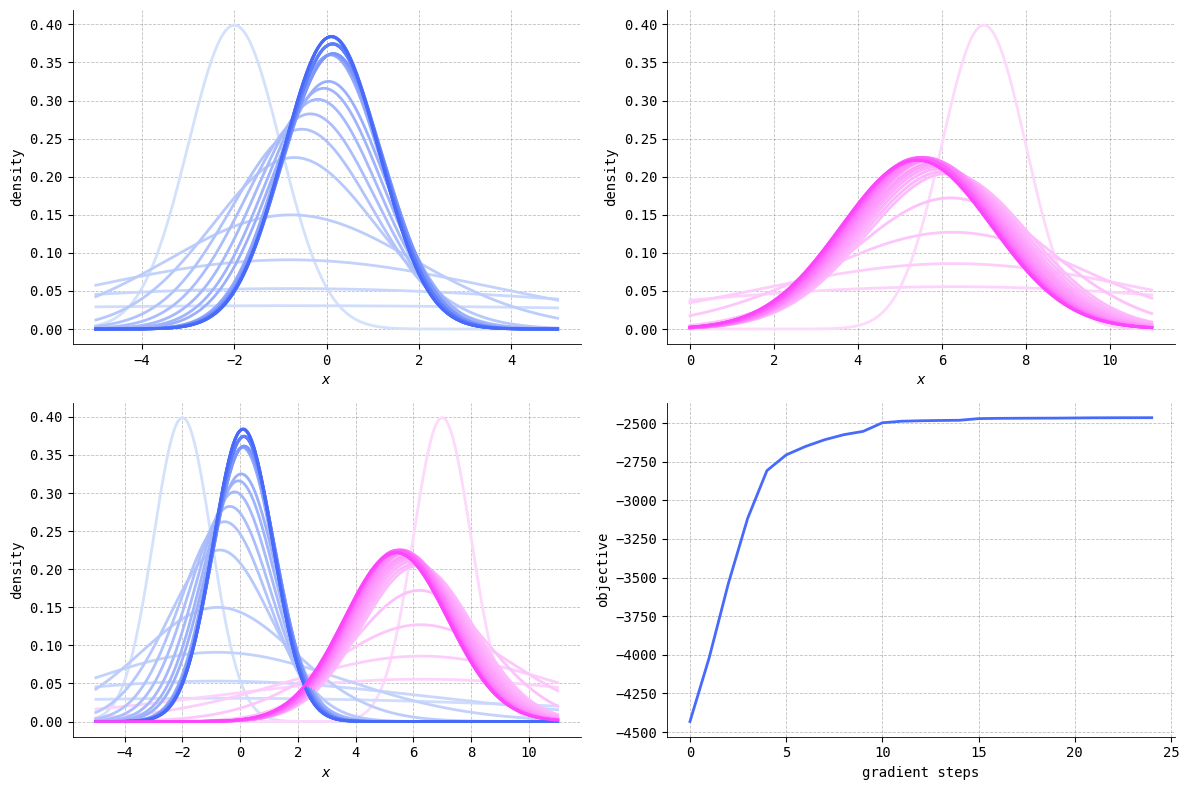

In [8]:
url = 'https://raw.githubusercontent.com/jmyers7/stats-book-materials/main/data/ch10-book-data-02.csv'
df = pd.read_csv(url)
X = torch.tensor(data=df['x'], dtype=torch.float32).reshape(-1, 1)

#
def parameter_transform(parameters):    
    return_dict = {'mu0': parameters['mu0'],
                   'mu1': parameters['mu1'],
                   'sigma0': torch.exp(parameters['sigma0_trans']),
                   'sigma1': torch.exp(parameters['sigma1_trans']),
                   'phi': torch.sigmoid(parameters['phi_trans'])}
    return return_dict

#
def log_joint(x, z, parameters):
    mu0, mu1, sigma0, sigma1, phi = parameters.values()
    mu = z * mu1 + (1 - z) * mu0
    sigma = z * sigma1 + (1 - z) * sigma0
    return Normal(loc=mu, scale=sigma).log_prob(x) + Bernoulli(probs=phi).log_prob(z)

def joint(x, z, parameters):
    return torch.exp(log_joint(x, z, parameters))

def log_marginal(x, parameters):
    z_zeros = torch.zeros(size=(len(x), 1))
    z_ones = torch.ones(size=(len(x), 1))
    return torch.log(joint(x, z_zeros, parameters) + joint(x, z_ones, parameters))

def log_posterior(z, x, parameters):
    return log_joint(x, z, parameters) - log_marginal(x, parameters)

def posterior(z, x, parameters):
    return torch.exp(log_posterior(z, x, parameters))

#
def sample_posterior(X, parameters, size=1, random_state=None):
    if random_state is not None:
        torch.manual_seed(42)
    trans_parameters = parameter_transform(parameters)
    z_ones = torch.ones(size=(len(X), 1))
    probs = posterior(z=z_ones, x=X, parameters=trans_parameters)
    epsilon = 1e-5
    probs = torch.clamp(input=probs, min=epsilon, max=1 - epsilon)
    return Bernoulli(probs=probs.squeeze()).sample((size,)).T

def J(X, parameters, sample):
    trans_parameters = parameter_transform(parameters)
    return -1 * torch.sum(log_joint(x=X, z=sample, parameters=trans_parameters), dim=0).mean()

# define the EM function
def EM(parameters, J, X, num_e_steps, sample_fn, sample_size, sgd_parameters, random_state=None):
    
    # initialize lists to track objective values and parameters
    running_objectives = []
    running_parameters = defaultdict(list)

    # begin loop for e-steps
    for _ in range(num_e_steps):

        # get a random sample to approximate the expectation
        sample = sample_fn(parameters=parameters, X=X, size=sample_size, random_state=random_state)

        # define arguments for the objective function to be passed into gradient descent
        J_args = {'sample': sample}

        # m-step (gradient descent)
        per_step_parameters, per_step_objectives = SGD(parameters=parameters,
                                                       J=J,
                                                       X=X,
                                                       J_args=J_args,
                                                       shuffle=False,
                                                       **sgd_parameters)

        # collect per-e-step objectives and parameters into the running list
        running_objectives.extend(per_step_objectives)
        for key in per_step_parameters.keys():
            running_parameters[key].extend(per_step_parameters[key])

    return dict(running_parameters), running_objectives

# 
parameters = {'mu0': torch.tensor([-2.], requires_grad=True),
              'mu1': torch.tensor([7.], requires_grad=True),
              'sigma0_trans': torch.tensor([0.], requires_grad=True),
              'sigma1_trans': torch.tensor([0.], requires_grad=True),
              'phi_trans': torch.tensor([0.], requires_grad=True)}
em_parameters = {'num_e_steps': 5,
                 'sample_size': 32,
                 'random_state': 42}
sgd_parameters = {'num_epochs': 5,
                  'batch_size': 1024,
                  'lr': 1e-3,
                  'decay': 0,
                  'tracking': 'gd_step'}

running_parameters, running_objectives = EM(parameters=parameters,
                                            J=J,
                                            X=X,
                                            sample_fn=sample_posterior,
                                            sgd_parameters=sgd_parameters,
                                            **em_parameters)

# the parameters are returned transformed, so we need to transform them back
transformed_dict = parameter_transform({key: torch.tensor(value) for key, value in running_parameters.items()})
running_parameters = {key: [parameter for parameter in value] for key, value in transformed_dict.items()}

num_e_steps = em_parameters['num_e_steps']
num_epochs = sgd_parameters['num_epochs']

blues = sns.color_palette('blend:#D4E1FB,#486AFB', n_colors=num_e_steps * num_epochs)
magentas = sns.color_palette('blend:#FDD9FC,#FD46FC', n_colors=num_e_steps * num_epochs)

_, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
grid_0 = np.linspace(-5, 5, num=300)
grid_1 = np.linspace(0, 11, num=300)
grid_0_1 = np.linspace(-5, 11, num=300)

for i in range(num_e_steps * num_epochs):
    mu0 = running_parameters['mu0'][i].item()
    mu1 = running_parameters['mu1'][i].item()
    sigma0 = running_parameters['sigma0'][i].item()
    sigma1 = running_parameters['sigma1'][i].item()

    X_0 = sp.stats.norm(loc=mu0, scale=sigma0)
    X_1 = sp.stats.norm(loc=mu1, scale=sigma1)
    
    axes[0, 0].plot(grid_0, X_0.pdf(grid_0), color=blues.as_hex()[i])
    axes[0, 1].plot(grid_1, X_1.pdf(grid_1), color=magentas.as_hex()[i])
    axes[1, 0].plot(grid_0_1, X_0.pdf(grid_0_1), color=blues.as_hex()[i])
    axes[1, 0].plot(grid_0_1, X_1.pdf(grid_0_1), color=magentas.as_hex()[i])

axes[0, 0].set_xlabel('$x$')
axes[0, 0].set_ylabel('density')
axes[0, 1].set_xlabel('$x$')
axes[0, 1].set_ylabel('density')
axes[1, 0].set_xlabel('$x$')
axes[1, 0].set_ylabel('density')
axes[1, 1].plot(range(num_e_steps * num_epochs), -torch.row_stack(running_objectives))
axes[1, 1].set_xlabel('gradient steps')
axes[1, 1].set_ylabel('objective')

plt.tight_layout()